In [364]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # plotting
import PdM_functions as pdm # custom functions created for this project that are used in several notebooks

In [367]:
# Load the data, merge, clean some columns and assign a timestamp column
df_set = pd.read_csv('data/Timeseries_Kaggle/TimeSeries.csv', sep = ",")
df_lab = pd.read_csv('data/Timeseries_Kaggle/labelsTimeSeries.csv', sep = ",")
df_set = pd.merge(df_set, df_lab, left_index=True, right_index=True)
df_set['label'] = df_set['label'].map({0: 'Normal', 1:'Abnormal'})
df_set.rename(columns = {'label': 'status'}, inplace = True)
df_set['timestamp'] = df_set.index
#df_set

Index(['v1', 'v2', 'v3', 'v4', 'v5', 'v6', 'v7', 'v8', 'v9', 'v10', 'v11',
       'status', 'timestamp'],
      dtype='object')


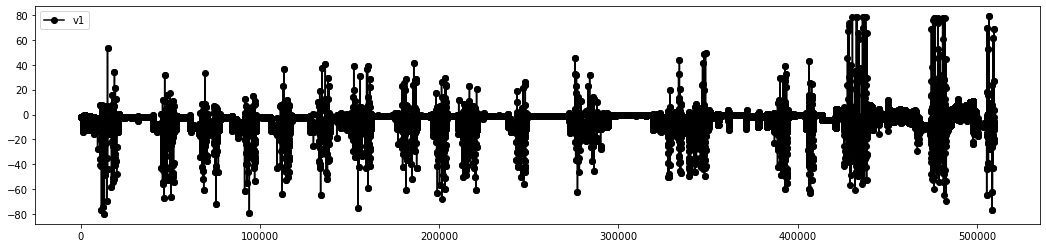

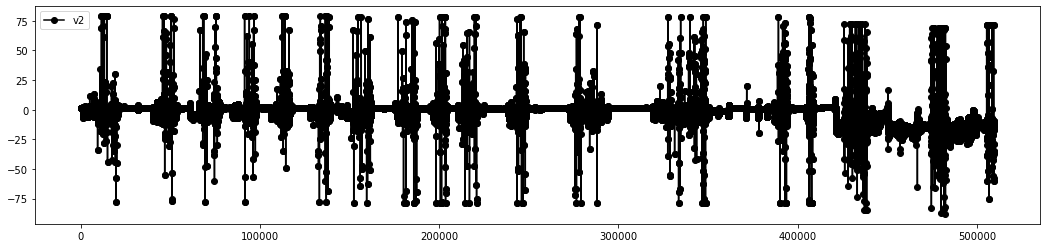

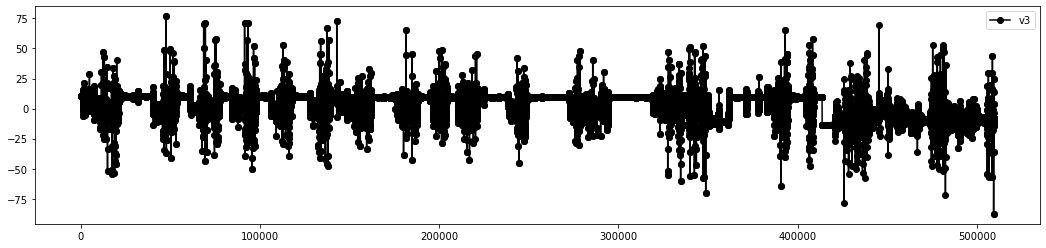

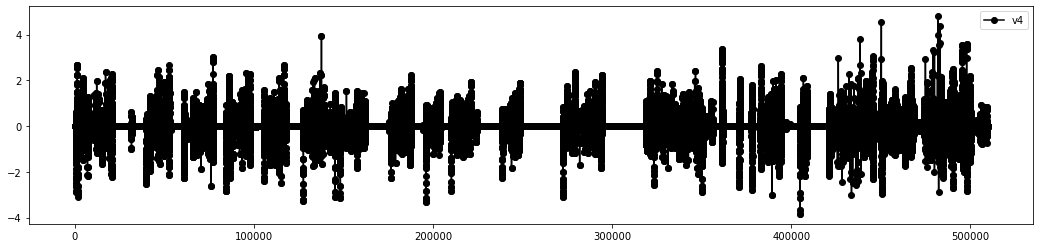

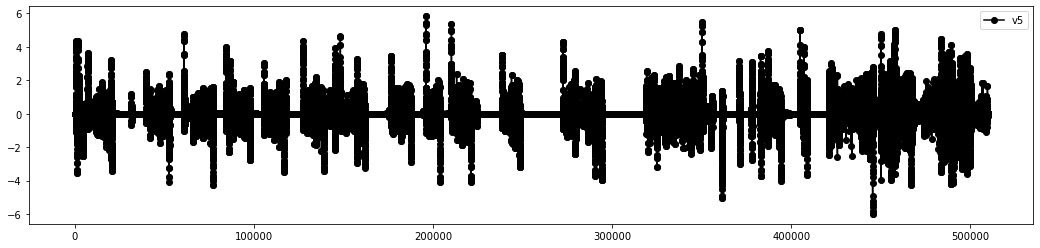

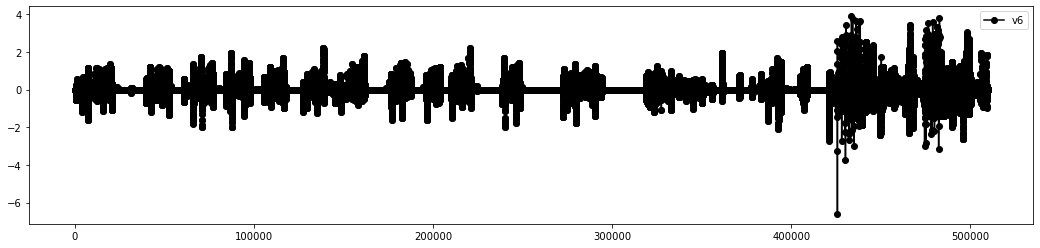

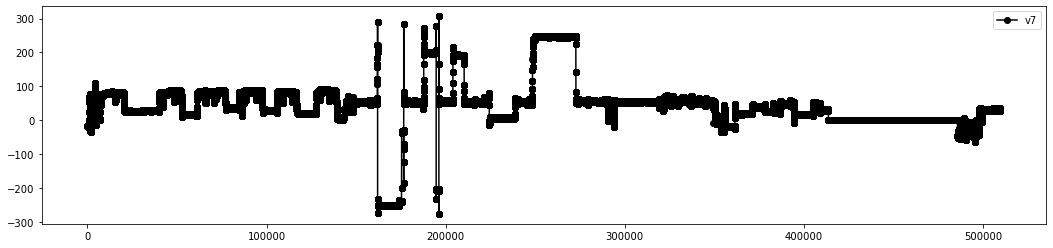

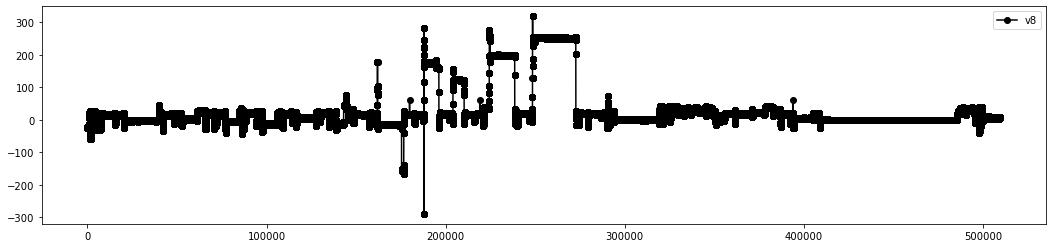

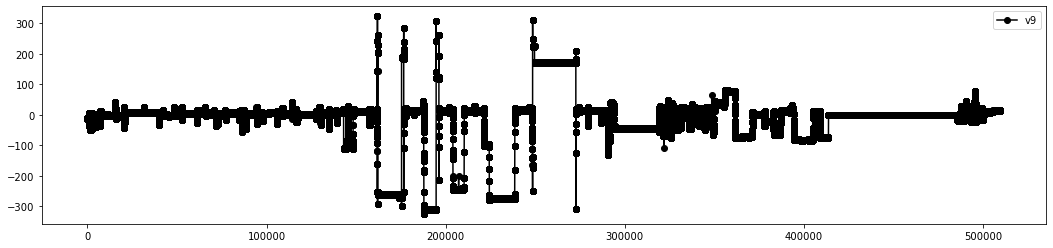

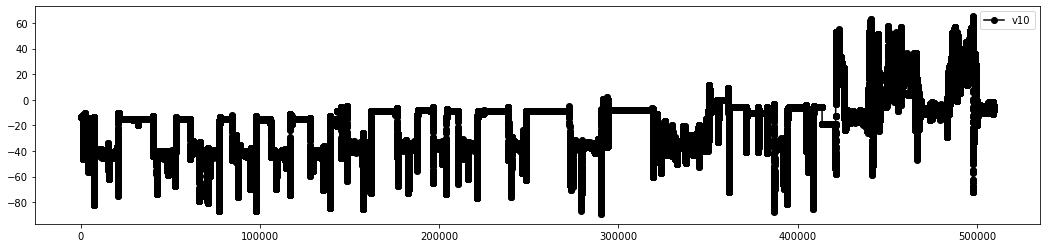

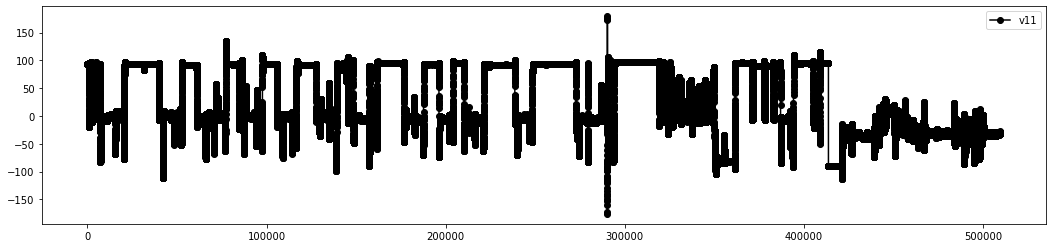

In [371]:
# Quick check of data
print(df_set.columns)
PLOT_ALL = True
if PLOT_ALL:
    plot_chans = df_set.columns.drop(['timestamp', 'status'])
else:
    plot_chans = ['v2']

for sen in plot_chans:
    df_set[[sen]].plot(figsize = (18, 4), color = 'black', marker = 'o')

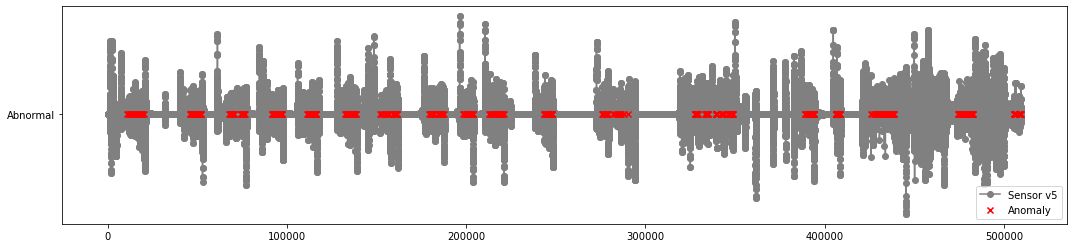

In [385]:
# Visualize status over time for the data using sensor v5 as reference
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(df_set['v5'], color = 'grey', marker = 'o', zorder = 1, label = 'Sensor v5')
anomaly_dat = df_set.loc[df_set['status'] == 'Abnormal', :]
ax.scatter(anomaly_dat.index, anomaly_dat['status'], color = 'red', marker = 'x', zorder = 1, label = 'Anomaly')
#ax.set_xlim(105000, 120000),
ax.legend(loc = 'lower right')
plt.show()

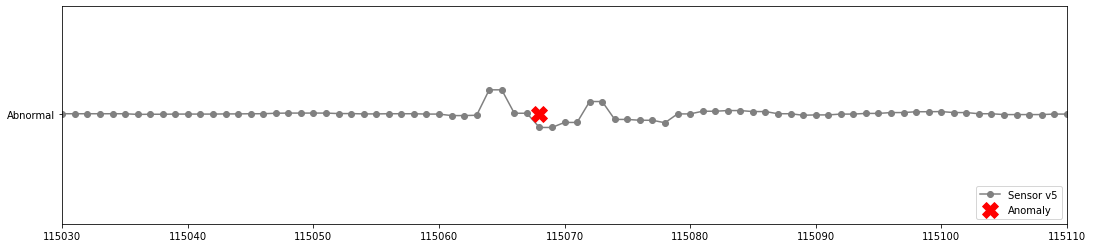

In [381]:
# Visualize machine status at one typical location (again using v5 as reference)
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(df_set['v5'], color = 'grey', marker = 'o', zorder = 1, label = 'Sensor v5')
anomaly_dat = df_set.loc[df_set['status'] == 'Abnormal', :]
ax.scatter(anomaly_dat.index, anomaly_dat['status'], color = 'red', marker = 'X', s = 250, zorder = 1, label = 'Anomaly')
ax.set_xlim(115030, 115110)
ax.legend(loc = 'lower right')
plt.show()

In [386]:
normal_pts = len(df_set.loc[df_set['status'] == 'Normal', :])
anomal_pts = len(df_set.loc[df_set['status'] == 'Abnormal', :])
print('No. of normal datapoints:', normal_pts)
print('No. of anomaly datapoints:', anomal_pts)
print('Anomaly percentage: ' + str(round(100*anomal_pts/normal_pts, 3)) + '%')

No. of normal datapoints: 509189
No. of anomaly datapoints: 443
Anomaly percentage: 0.087%


### Data Scaling

In [387]:
from sklearn import preprocessing
from sklearn.decomposition import PCA
from matplotlib import gridspec
from matplotlib.pyplot import figure
from itertools import groupby

In [388]:
# Scale the data (between 0 and 1)
df_num = df_set.drop(['status'], axis = 1)
scaler = preprocessing.StandardScaler()
df_set_scaled = pd.DataFrame(scaler.fit_transform(df_num), columns = df_num.columns, index = df_num.index)
df_set_scaled['status'] = df_set['status']
df_set_scaled.describe()

,v1,v2,v3,v4,v5,v6,v7,v8,v9,v10,v11,timestamp
count,5.096320e+05,5.096320e+05,5.096320e+05,5.096320e+05,5.096320e+05,5.096320e+05,5.096320e+05,5.096320e+05,5.096320e+05,5.096320e+05,5.096320e+05,5.096320e+05
mean,-4.131374e-16,1.088613e-16,1.159997e-17,-6.775944e-18,4.658461e-18,4.322104e-18,5.599216e-17,6.469214e-18,-9.859974e-17,1.188997e-16,-3.926143e-17,-3.658452e-17
std,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00,1.000001e+00
min,-1.640617e+01,-1.381973e+01,-1.170753e+01,-1.780917e+01,-1.738754e+01,-3.818950e+01,-4.155051e+00,-4.937219e+00,-3.428929e+00,-3.563101e+00,-3.574645e+00,-1.732047e+00
25%,-8.527029e-01,-2.784876e-01,-4.093395e-01,-8.859463e-03,-7.161738e-03,-2.600764e-03,-4.651343e-01,-4.672465e-01,2.281937e-02,-8.199575e-01,-6.292211e-01,-8.660237e-01
50%,4.867151e-01,4.186051e-02,-2.368280e-01,-8.859463e-03,-7.161738e-03,-2.600764e-03,4.326651e-02,-2.221938e-01,2.031604e-01,1.853062e-01,-5.067709e-01,0.000000e+00
75%,8.506159e-01,7.642782e-01,9.864349e-01,-8.859463e-03,2.185392e-02,-2.600764e-03,2.291713e-01,-1.253161e-01,3.189348e-01,5.301556e-01,1.111383e+00,8.660237e-01
max,1.838581e+01,1.343928e+01,9.788439e+00,2.224152e+01,1.690897e+01,2.250452e+01,3.443955e+00,4.449259e+00,3.787493e+00,4.236150e+00,2.620674e+00,1.732047e+00


In [389]:
# Calculate the run length encoding
rle = [(k, sum(1 for i in g)) for k, g in groupby(df_set_scaled['status'])]

In [390]:
# Check run length streaks so we can pick a suitable window to use 
# to classify an anomaly window
max_norm_streak = 0  
min_norm_streak = len(rle)  
for j in range(len(rle)):
    if rle[j][0] == 'Normal':
        chk_streak = int(rle[j][1])        
        if chk_streak > max_norm_streak:
            max_norm_streak = chk_streak
        if chk_streak < min_norm_streak:
            min_norm_streak = chk_streak    
print('Max normal run length: ', max_norm_streak)
print('Min normal run length: ', min_norm_streak)

Max normal run length:  40074
Min normal run length:  14


In [391]:
# Assign a number of datapoints before and after the recorded anomaly
# to the 'anomaly window'
trans_win = 1*10

# Create map to reduce categories to two
condition_map = {'Normal': 'Normal', 'Abnormal': 'Abnormal'}

In [392]:
df_set_scaled['timestamp'] = df_set_scaled.index

In [393]:
# Create a 'normal' and 'abonormal' dataset
df_norm, df_abnorm = pdm.remove_segements(
    segment_vec = df_set_scaled['status'],
    mapping = condition_map,
    dat = df_set_scaled,
    trans_window = trans_win, # datapoints to extract before and after anomaly
    keep = 'Normal'
)

Input segement categories:  ['Normal' 'Abnormal']
Categories after mapping:  ['Normal' 'Abnormal']
Run length encoding:  [('Normal', 10702), ('Abnormal', 1), ('Normal', 721), ('Abnormal', 1), ('Normal', 460), ('Abnormal', 1), ('Normal', 434), ('Abnormal', 1), ('Normal', 382), ('Abnormal', 1), ('Normal', 335), ('Abnormal', 1), ('Normal', 430), ('Abnormal', 1), ('Normal', 391), ('Abnormal', 1), ('Normal', 510), ('Abnormal', 1), ('Normal', 430), ('Abnormal', 1), ('Normal', 2221), ('Abnormal', 1), ('Normal', 242), ('Abnormal', 1), ('Normal', 367), ('Abnormal', 1), ('Normal', 386), ('Abnormal', 1), ('Normal', 354), ('Abnormal', 1), ('Normal', 303), ('Abnormal', 1), ('Normal', 285), ('Abnormal', 1), ('Normal', 229), ('Abnormal', 1), ('Normal', 393), ('Abnormal', 1), ('Normal', 333), ('Abnormal', 1), ('Normal', 25589), ('Abnormal', 1), ('Normal', 339), ('Abnormal', 1), ('Normal', 283), ('Abnormal', 1), ('Normal', 301), ('Abnormal', 1), ('Normal', 272), ('Abnormal', 1), ('Normal', 203), ('Abno

>
Skipping Normal segment(s)...
>
Remove rows:  [12310, 12330]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [12693, 12713]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [13029, 13049]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [13460, 13480]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [13852, 13872]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [14363, 14383]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [14794, 14814]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [17016, 17036]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [17259, 17279]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [17627, 17647]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [18014, 18034]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [18369, 18389]
Removing 21 rows...
>
Sk

>
Skipping Normal segment(s)...
>
Remove rows:  [133597, 133617]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [133740, 133760]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [133892, 133912]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [134434, 134454]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [136070, 136090]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [136355, 136375]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [136647, 136667]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [136910, 136930]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [137299, 137319]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [137552, 137572]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [137760, 137780]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [138088, 138108]


>
Skipping Normal segment(s)...
>
Remove rows:  [244440, 244460]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [244999, 245019]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [245293, 245313]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [245640, 245660]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [245895, 245915]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [246178, 246198]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [246838, 246858]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [247084, 247104]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [247312, 247332]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [247463, 247483]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [247589, 247609]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [247695, 247715]


>
Skipping Normal segment(s)...
>
Remove rows:  [390799, 390819]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [391071, 391091]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [391296, 391316]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [391601, 391621]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [391919, 391939]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [392675, 392695]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [392745, 392765]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [392800, 392820]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [392838, 392858]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [392882, 392902]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [392918, 392938]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [392951, 392971]


>
Skipping Normal segment(s)...
>
Remove rows:  [478365, 478385]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [478601, 478621]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [478902, 478922]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [479174, 479194]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [479395, 479415]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [479635, 479655]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [479904, 479924]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [480919, 480939]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [481131, 481151]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [481362, 481382]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [481586, 481606]
Removing 21 rows...
>
Skipping Normal segment(s)...
>
Remove rows:  [481781, 481801]


In [394]:
# Check row counts
tot_rows = len(df_norm) + len(df_abnorm)
print('Nrows normal: ' + str(len(df_norm)) + ' (' + str(round(100*len(df_norm)/tot_rows)) + '%)')
print('Nrows abnorm: ' + str(len(df_abnorm)) + ' (' + str(round(100*len(df_abnorm)/tot_rows)) + '%)')

Nrows normal: 500352 (98%)
Nrows abnorm: 9280 (2%)


In [395]:
# Prepare data for PCA
df_train = df_norm
df_train = df_train.drop(['status', 'timestamp'], axis = 1)                      

df_test1 = df_abnorm
df_test1 = df_test1.drop(['status', 'timestamp'], axis = 1) 

### PCA

In [396]:
# Define the PCA model (all compoments)
# from sklearn.decomposition import PCA, KernelPCA
n_comps = 10 # How many dimensions you want to reduce to
pca = PCA(n_components = n_comps, svd_solver = 'full')

# Compute PCA components for the training set
X_train_PCA = pca.fit_transform(df_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = df_train.index

# Project the test data onto the PCA space
X_test1_PCA = pca.transform(df_test1)
X_test1_PCA = pd.DataFrame(X_test1_PCA)
X_test1_PCA.index = df_test1.index

# Print the explained variance
# 3 decimal places and don't use scientific notation
np.set_printoptions(precision = 3, suppress=True) 
print('Explained variance:', pca.explained_variance_ratio_)

Explained variance: [0.29  0.187 0.15  0.137 0.082 0.071 0.03  0.027 0.021 0.004]


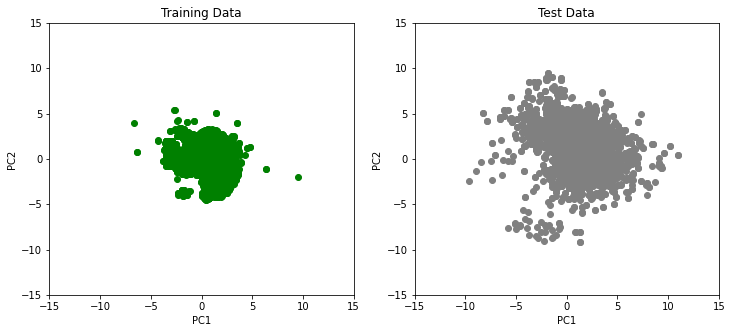

In [397]:
# Plot PC1 vs PC2 for training & test sets
fig, axes = plt.subplots(1, 2, figsize = (12, 5))
gs = gridspec.GridSpec(1, 2, width_ratios = [1, 1])

ax0 = plt.subplot(gs[0])
ax0.scatter(X_train_PCA.loc[:, 0], X_train_PCA.loc[:, 1], color = 'green')
ax0.set_xlabel('PC1')
ax0.set_ylabel('PC2')
ax0.set_xlim(-15, 15)
ax0.set_ylim(-15, 15)
ax0.set_title('Training Data')

ax1 = plt.subplot(gs[1])
ax1.scatter(X_test1_PCA.loc[:, 0], X_test1_PCA.loc[:, 1], color = 'grey')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_xlim(-15, 15)
ax1.set_ylim(-15, 15)
ax1.set_title('Test Data')

plt.show()

In [398]:
# Move on to calculate Mahalanobis Distance 
# This is a multivatiate distance from centroid calculation that
# can be useful for unsupervised anomaly detection
data_train = np.array(X_train_PCA.values)
data_test1 = np.array(X_test1_PCA.values)

cov_matrix = np.cov(data_train, rowvar = False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Mean of each column: PC1, PC2 (it should be very close to zero)
mean_distr = data_train.mean(axis = 0) # axis=0 means that average is computed per column
np.set_printoptions(precision = 3, suppress = False)
print('Mean distr', mean_distr)

# Mahalanobis Distance calculation
dist_test1 = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_test1, verbose=False)
dist_train = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)

print("Minimum & maximum MD in training set:", min(dist_train), max(dist_train))
print("Minimum & maximum MD in test set 1  :", min(dist_test1), max(dist_test1))

threshold = pdm.MD_threshold(dist_train, extreme = True) # extreme = True; 2x mean of incoming data
print("Threshold value for flagging an anomaly is", "{:.2f}".format(threshold))

Mean distr [-9.997e-18 -5.908e-17 -3.388e-17  3.613e-17  9.291e-18 -1.727e-17
  4.345e-17  6.317e-17  2.323e-17 -9.248e-17]
Minimum & maximum MD in training set: 0.7395504698371765 46.21451825455277
Minimum & maximum MD in test set 1  : 0.967227603721574 92.85652069617595
Threshold value for flagging an anomaly is 7.81


/Users/jasonpayne/opt/anaconda3/envs/pdm/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


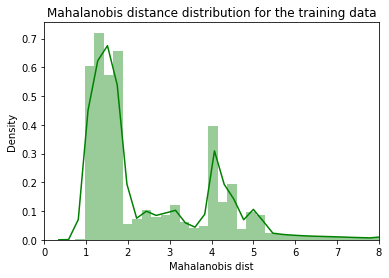

In [399]:
import seaborn as sns
plt.figure()
sns.distplot(dist_train,
             bins = 200, 
             kde = True, 
            color = 'green');
plt.xlim([0.0, 8])
plt.xlabel('Mahalanobis dist')
plt.title('Mahalanobis distance distribution for the training data')
plt.show()

In [400]:
# Prepare training data for visualization
# If Mahalonobis distance is above threshold: Flag as anomaly
anomaly_train = pdm.prep_mahalonobis_data(dist_train, threshold, X_train_PCA)
anomaly1 = pdm.prep_mahalonobis_data(dist_test1, threshold, X_test1_PCA)

There are 9369 anomalies in the test set out of 500352 points
> Corresponding to 1.87%
There are 3167 anomalies in the test set out of 9280 points
> Corresponding to 34.13%


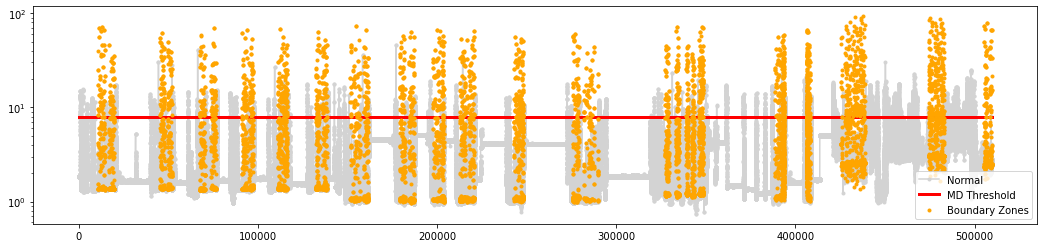

In [401]:
nrows = len(df_set)

# Visualize Mahalonobis distance with actual anomalies vs threshold  
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(anomaly_train['timestamp'], anomaly_train['Mob dist'], color = 'lightgrey', marker = '.', zorder = 1, label = 'Normal')
ax.plot((0, nrows), (threshold, threshold), color = 'red', marker = None, linewidth = 3, zorder = 2, label = 'MD Threshold')
ax.scatter(anomaly1['timestamp'], anomaly1['Mob dist'], color = 'orange', marker = '.', zorder = 3, label = 'Boundary Zones')
ax.set_yscale('log')
ax.legend(loc = 'lower right')
plt.show()

In [402]:
# Define plot xlims for each anomaly window plot
df_ser = df_set.loc[df_set['status'] == 'Abnormal',:]
n_plots = len(df_ser)
buff = 50
start_win = []
ender_win = []
for r in range(n_plots):
    start_win.append(df_ser.iloc[r, 12] - buff)
    ender_win.append(df_ser.iloc[r, 12] + buff)

In [403]:
# Add missing data to gaps between anomalies
df_set.reset_index(drop = True, inplace = True)
anomaly_train.reset_index(drop = True, inplace = True)
anomaly_train_plt = pd.merge(df_set, anomaly_train, how='left', on='timestamp')
anomaly1.reset_index(drop = True, inplace = True)
anomaly1_plt = pd.merge(df_set['timestamp'], anomaly1, how='left', on='timestamp')

In [404]:
# Now lets count the number of anomaly windows 
# and check each window for a breach of the threshold
# i.e., at least one point breaching the threshold in the window
anomaly1_plt.loc[anomaly1_plt['Thresh'].isnull(), 'Anomaly'] = 'Normal'
anomaly1_plt.loc[anomaly1_plt['Thresh'].notnull(), 'Anomaly'] = 'Anomaly'
#print(anomaly1_plt.iloc[10690:10715,:])

# Calculate the run length encoding
rle_anomalies = [(k, sum(1 for i in g)) for k, g in groupby(anomaly1_plt['Anomaly'])]
#print('Run length encoding: ', rle_anomalies)

In [405]:
# Loop through and number windows based on run length encoding
anomaly1_plt['anomaly_number'] = 0
prev = 0
counter = 1
for j in range(len(rle_anomalies)):
    if rle_anomalies[j][0] == 'Normal':
        #print(rle_anomalies[j][0])
        prev = prev + rle_anomalies[j][1]
        next
    elif j == 0:
        prev = prev + rle_anomalies[j][1]
        #print(range(0, rle_anomalies[j][1], 1))
        anomaly1_plt.loc[anomaly1_plt.index.isin(list(range(0, rle_anomalies[j][1], 1))),'anomaly_number'] = counter 
        counter += 1
    else:        
        goto = prev + rle_anomalies[j][1]
        #print(range(prev, goto, 1))
        anomaly1_plt.loc[anomaly1_plt.index.isin(list(range(prev, goto, 1))),'anomaly_number'] = counter
        prev = prev + rle_anomalies[j][1]
        counter += 1

In [406]:
# Now summarise and count how many were missed, i.e., false negatives
count_anomaly_blks = anomaly1_plt.loc[anomaly1_plt['anomaly_number'] != 0,:]
count_anomaly_blks = max(count_anomaly_blks['anomaly_number'])
anom_chk = []
anom_num = []

for a in range(count_anomaly_blks):
    anom_num.append(a + 1)
    dat = anomaly1_plt.loc[anomaly1_plt['anomaly_number'] == a+1,:]
    max_mobdi = max(dat['Mob dist'])
    max_thres = max(dat['Thresh'])
    if max_mobdi >= max_thres:
        anom_chk.append(1)
    else: 
        anom_chk.append(0)
        
result_summary = pd.DataFrame()
result_summary['anom_num'] = anom_num
result_summary['anom_chk'] = anom_chk
FN = len(result_summary.loc[result_summary['anom_chk'] == 0,:])
AN = len(result_summary)
print(f'Missed {FN} out of {AN} ({round(100*FN/AN, 2)}%)\n')
print(result_summary.loc[result_summary['anom_chk'] == 0,:])

Missed 4 out of 430 (0.93%)

     anom_num  anom_chk
82         83         0
180       181         0
267       268         0
270       271         0


In [407]:
# Now lets plot each window and verify
PLOT_WINS = False
if PLOT_WINS:
    for p in range(n_plots):
        fig, ax = plt.subplots(figsize = (18, 4))
        ax.plot(anomaly_train_plt['timestamp'], anomaly_train_plt['Mob dist'], color = 'lightgrey', marker = '.', zorder = 1, label = 'Normal')
        ax.plot((0, nrows), (threshold, threshold), color = 'red', marker = None, linewidth = 3, zorder = 2, label = 'MD Threshold')
        ax.plot(anomaly1_plt['timestamp'], anomaly1_plt['Mob dist'], color = 'orange', marker = 'X', zorder = 3, linewidth = 3, label = f'Anomaly Window {p+1}')
        ax.set_yscale('log')
        ax.legend(loc = 'lower right')
        #ax.set_xlim(115030, 115110)
        ax.set_xlim(start_win[p], ender_win[p])
        plt.show()

### Robust Principle Component Analysis (R-PCA)

In [153]:
df_num_scaled = pd.DataFrame(scaler.fit_transform(df_num), columns = df_num.columns, index = df_num.index)

train_rows = df_train.index
test1_rows = df_test1.index

df_train = df_num_scaled.loc[df_num_scaled.index.isin(train_rows),:]
df_test1 = df_num_scaled.loc[df_num_scaled.index.isin(test1_rows),:]

In [154]:
print(len(df_train))
print(len(df_test1))

500352
9280


In [157]:
# Compute all low rank & sparse matrices for data
L, S = pdm.R_pca(df_num_scaled).fit()

iteration: 1, error: 0.5973017067143815
iteration: 3, error: 0.00020213795196055028


In [167]:
df_train = L[train_rows,]
df_test = L[test1_rows,]

In [170]:
X_train_PCA = pca.fit_transform(df_train)
X_train_PCA = pd.DataFrame(X_train_PCA)
X_train_PCA.index = train_rows

# Project the test data onto the PCA space
X_test1_PCA = pca.transform(df_test1)
X_test1_PCA = pd.DataFrame(X_test1_PCA)
X_test1_PCA.index = test1_rows

In [171]:
# 3 decimal places and don't use scientific notation
np.set_printoptions(precision = 3, suppress = True) 
print('Explained variance:', pca.explained_variance_ratio_)

Explained variance: [0.29  0.187 0.15  0.137 0.082 0.07  0.03  0.027 0.021 0.004]


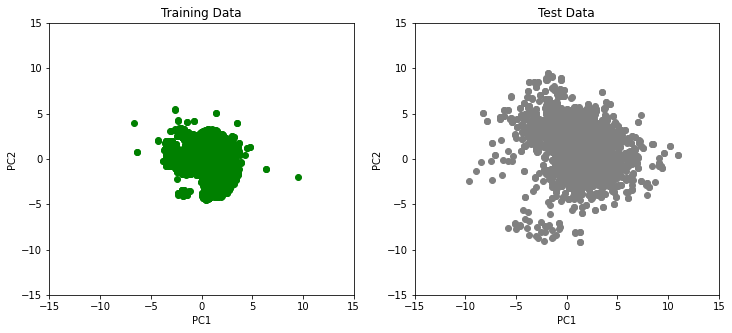

In [172]:
# Plot PC1 vs PC2 for training & test sets
fig, axes = plt.subplots(1, 2, figsize = (12, 5))
gs = gridspec.GridSpec(1, 2, width_ratios = [1, 1])

ax0 = plt.subplot(gs[0])
ax0.scatter(X_train_PCA.loc[:, 0], X_train_PCA.loc[:, 1], color = 'green')
ax0.set_xlabel('PC1')
ax0.set_ylabel('PC2')
ax0.set_xlim(-15, 15)
ax0.set_ylim(-15, 15)
ax0.set_title('Training Data')

ax1 = plt.subplot(gs[1])
ax1.scatter(X_test1_PCA.loc[:, 0], X_test1_PCA.loc[:, 1], color = 'grey')
ax1.set_xlabel('PC1')
ax1.set_ylabel('PC2')
ax1.set_xlim(-15, 15)
ax1.set_ylim(-15, 15)
ax1.set_title('Test Data')

plt.show()

In [183]:
# Move on to calculate Mahalanobis Distance 
# This is a multivatiate distance from centroid calculation that
# can be useful for unsupervised anomaly detection
data_train = np.array(X_train_PCA.values)
data_test1 = np.array(X_test1_PCA.values)

cov_matrix = np.cov(data_train, rowvar = False)
inv_cov_matrix = np.linalg.inv(cov_matrix)

# Mean of each column: PC1, PC2 (it should be very close to zero)
mean_distr = data_train.mean(axis = 0) # axis=0 means that average is computed per column
np.set_printoptions(precision = 3, suppress = False)
print('Mean distr', mean_distr)

# Mahalanobis Distance calculation
dist_test1 = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_test1, verbose=False)
dist_train = pdm.MahalanobisDist(inv_cov_matrix, mean_distr, data_train, verbose=False)

print("Minimum & maximum MD in training set:", min(dist_train), max(dist_train))
print("Minimum & maximum MD in test set 1  :", min(dist_test1), max(dist_test1))

threshold = pdm.MD_threshold(dist_train, extreme = True) # extreme = True; 2x mean of incoming data
print("Threshold value for flagging an anomaly is", "{:.2f}".format(threshold))

Mean distr [ 4.593e-15  2.647e-15  7.371e-16  3.591e-15  1.379e-16 -2.167e-15
  5.183e-18  1.582e-15 -9.054e-16 -7.006e-15]
Minimum & maximum MD in training set: 0.7400825158247332 46.14472122059108
Minimum & maximum MD in test set 1  : 0.9675229146589163 92.97956346636398
Threshold value for flagging an anomaly is 7.81


/Users/jasonpayne/opt/anaconda3/envs/pdm/lib/python3.8/site-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


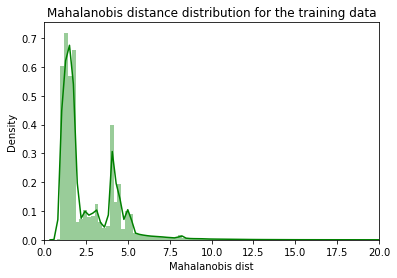

In [184]:
import seaborn as sns
plt.figure()
sns.distplot(dist_train,
             bins = 200, 
             kde= True, 
            color = 'green');
plt.xlim([0.0, 20])
plt.xlabel('Mahalanobis dist')
plt.title('Mahalanobis distance distribution for the training data')
plt.show()

In [185]:
#threshold = 18

In [186]:
# Prepare training data for visualization
# If Mahalonobis distance is above threshold: Flag as anomaly
anomaly_train = pdm.prep_mahalonobis_data(dist_train, threshold, X_train_PCA)
anomaly1 = pdm.prep_mahalonobis_data(dist_test1, threshold, X_test1_PCA)

There are 9364 anomalies in the test set out of 500352 points
> Corresponding to 1.87%
There are 3167 anomalies in the test set out of 9280 points
> Corresponding to 34.13%


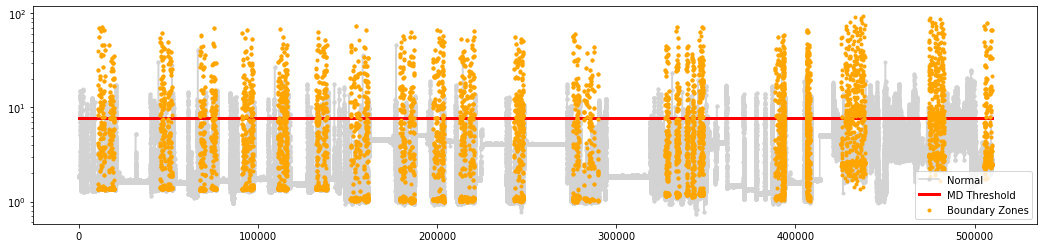

In [187]:
# Visualize Mahalonobis distance with actual anomalies vs threshold  
fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(anomaly_train['timestamp'], anomaly_train['Mob dist'], color = 'lightgrey', marker = '.', zorder = 1, label = 'Normal')
ax.plot((0, nrows), (threshold, threshold), color = 'red', marker = None, linewidth = 3, zorder = 2, label = 'MD Threshold')
ax.scatter(anomaly1['timestamp'], anomaly1['Mob dist'], color = 'orange', marker = '.', zorder = 3, label = 'Boundary Zones')
ax.set_yscale('log')
ax.legend(loc = 'lower right')
plt.show()

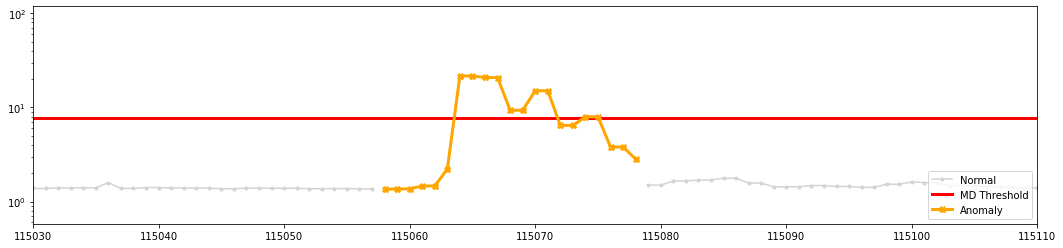

In [188]:
df_set.reset_index(drop = True, inplace = True)
anomaly_train.reset_index(drop = True, inplace = True)
anomaly_train_plt = pd.merge(df_set, anomaly_train, how='left', on='timestamp')
anomaly1.reset_index(drop = True, inplace = True)
anomaly1_plt = pd.merge(df_set['timestamp'], anomaly1, how='left', on='timestamp')

fig, ax = plt.subplots(figsize = (18, 4))
ax.plot(anomaly_train_plt['timestamp'], anomaly_train_plt['Mob dist'], color = 'lightgrey', marker = '.', zorder = 1, label = 'Normal')
ax.plot((0, nrows), (threshold, threshold), color = 'red', marker = None, linewidth = 3, zorder = 2, label = 'MD Threshold')
ax.plot(anomaly1_plt['timestamp'], anomaly1_plt['Mob dist'], color = 'orange', marker = 'X', zorder = 3, linewidth = 3, label = 'Anomaly')
ax.set_yscale('log')
ax.legend(loc = 'lower right')
ax.set_xlim(115030, 115110)
plt.show()